In [1]:
import os
import time
import warnings
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

from sgimc.utils import save, load

In [2]:
PATH_TO_EXP = '/cobrain/groups/ml_group/experiments/dustpelt/imc_exp/'
PATH_DATA = os.path.join(PATH_TO_EXP, 'data/n_instances')

In [3]:
def get_final_results(results, param='train_size', hyp_param='C_group'):
    # grouping by validation
    id_result = {}
    param_ids = defaultdict(list)

    for _id, result in enumerate(results):
        comb = '{}|{}'.format(result[param], result[hyp_param])
        param_ids[comb].append(_id)

        id_result[_id] = [result[param], result[hyp_param], result['val_score'], result['test_score']]

    id_groups = list(param_ids.values())

    # averaging the cross-validation results
    results_avg = []

    for ids in id_groups:
        val_res = [id_result[_id] for _id in ids]
        avg_res = np.mean(val_res, axis=0)
        results_avg.append(avg_res)

    results_avg = np.array(results_avg)

    # grouping by train_size
    id_result = {}
    param_ids = defaultdict(list)

    for _id, val_res in enumerate(results_avg):
        comb = '{}'.format(val_res[0])
        param_ids[comb].append(_id)

        id_result[_id] = val_res[[0,2,3]]

    id_groups = list(param_ids.values())

    results_final = []

    for ids in id_groups:
        param_res = results_avg[ids]
        val = [x[2] for x in param_res]
        chosen_result = param_res[np.argmin(val)]
        results_final.append(chosen_result[[0,3]])

    results_final = np.array(results_final)
    
    return results_final.T

## SGIMC

In [4]:
PATH_ARCH = os.path.join(PATH_DATA, 'arch_sgimc')

filename_results = []
filename_results.append(os.path.join(PATH_DATA, 'results_sgimc.gz'))

for fn in os.listdir(PATH_ARCH):
    filename_results.append(os.path.join(PATH_ARCH, fn))

In [5]:
results = []
for fn in filename_results:
    results.append(load(fn))

In [6]:
results_final = []
for result in results:
    results_final.append(get_final_results(result))
results_final = np.array(results_final)
results_sgimc = np.mean(results_final, axis=0)

## IMC

In [7]:
PATH_ARCH = os.path.join(PATH_DATA, 'arch_imc')

filename_results = []
filename_results.append(os.path.join(PATH_DATA, 'results_imc.gz'))

for fn in os.listdir(PATH_ARCH):
    filename_results.append(os.path.join(PATH_ARCH, fn))

In [8]:
results = []
for fn in filename_results:
    results.append(load(fn))

In [9]:
results_final = []
for result in results:
    results_final.append(get_final_results(result, hyp_param='lamb'))
results_final = np.array(results_final)
results_imc = np.mean(results_final, axis=0)

## Plots

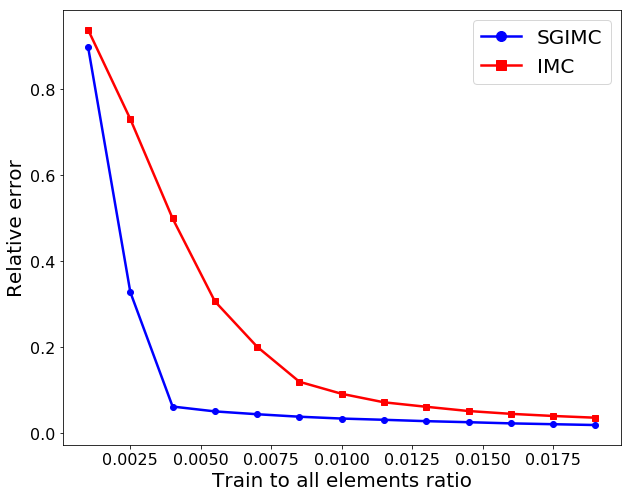

In [10]:
plt.figure(figsize=(10,8))

# lines
sgimc_line = mlines.Line2D([], [], color='blue', marker='o', linewidth=2.5,
                           markersize=10, label='SGIMC')
imc_line = mlines.Line2D([], [], color='red', marker='s', linewidth=2.5,
                         markersize=10, label='IMC')

# curves
plt.plot(results_sgimc[0], results_sgimc[1], 'b-', label='SGIMC', linewidth=2.5)
plt.plot(results_imc[0], results_imc[1], 'r-', label='IMC', linewidth=2.5)

# dotes
plt.plot(results_sgimc[0], results_sgimc[1], 'bo', label='SGIMC', linewidth=2.5)
plt.plot(results_imc[0], results_imc[1], 'rs', label='IMC', linewidth=2.5)

# specify axis limits and labels
#plt.ylim((0.4,1.02))
plt.xlabel('Train to all elements ratio', fontsize=20)
plt.ylabel('Relative error', fontsize=20)

# ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# legend
plt.legend(handles=[sgimc_line, imc_line], fontsize=20, loc=1)

# save figure
# plt.savefig('/cobrain/home/Dustpelt/SGIMC/plots/n_instances.pdf', dpi=200, bbox_inches='tight')

plt.show()